# Assignment 3

Imports

In [32]:
import numpy as np
import scipy as sp
from scipy.optimize import dual_annealing, curve_fit
from scipy.integrate import solve_ivp, odeint
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from numba import jit, njit, prange
import math
import os
import random
import logging

In [63]:
SEED = 33
np.random.seed(SEED)

os.makedirs('media', exist_ok=True)
logging.basicConfig(filename='default_log.log', level=logging.INFO)

if not os.path.isfile('predator-prey-data.csv'):
    raise FileNotFoundError("File 'predator-prey-data.csv' not found.")

data = pd.read_csv('predator-prey-data.csv').drop(columns=['Unnamed: 0'])
t, x, y = data['t'].to_numpy(), data['x'].to_numpy(), data['y'].to_numpy()

In [64]:
LOW_PARAM_BOUND = 0
UP_PARAM_BOUND = 2
MAX_STEPS_HILLCLIMING = 500
MAX_ITER_SA = 100

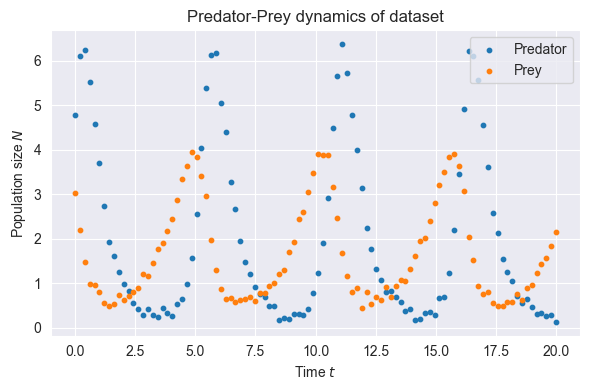

In [65]:
plt.figure(figsize=(6, 4), layout='tight')
plt.scatter(t, x, s=10, label='Predator')
plt.scatter(t, y, s=10, label='Prey')
plt.title('Predator-Prey dynamics of dataset')
plt.xlabel('Time $t$')
plt.ylabel('Population size $N$')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('media/dataset.png')
plt.show()

In [66]:
def solve_lv(params, init_conditions, t):
    alpha, beta, gamma, delta = params

    def lv_odes(y, t):
        x, z = y
        dxdt = alpha*x - beta*x*z
        dzdt = delta*x*z - gamma*z
        return np.array([dxdt, dzdt])

    solution = odeint(lv_odes, init_conditions, t)
    return solution

In [67]:
def get_initial_random_guess(lower_bound=LOW_PARAM_BOUND, upper_bound=UP_PARAM_BOUND):
    alpha = random.uniform(lower_bound, upper_bound)
    beta = random.uniform(lower_bound, upper_bound)
    gamma = random.uniform(lower_bound, upper_bound)
    delta = random.uniform(lower_bound, upper_bound)
    return [alpha, beta, gamma, delta]

In [68]:
def get_neighbors(solution, step_size=0.1):
    """Calculate the neighbors of a solution, given a step size."""
    neighbors = []
    for i in range(len(solution)):
        # Add step_size to the parameter if it doesn't exceed PARAM_MAX
        if solution[i] + step_size <= UP_PARAM_BOUND:
            neighbors.append(
                [solution[j] if j != i else solution[i] + step_size for j in range(len(solution))])
        # Subtract step_size from the parameter if it doesn't become less than PARAM_MIN
        if solution[i] - step_size >= LOW_PARAM_BOUND:
            neighbors.append(
                [solution[j] if j != i else solution[i] - step_size for j in range(len(solution))])
    return neighbors


def choose_next_step(loss_function, current_step):
    neighbors = get_neighbors(current_step)
    return min(neighbors, key=loss_function)


def hill_climbing(loss_function, initial_step, max_steps):
    """Perform the Hill Climbing optimization algorithm."""
    current_step = initial_step
    history = [current_step]

    for _ in range(max_steps):
        try:
            next_step = choose_next_step(loss_function, current_step)
            if loss_function(next_step) >= loss_function(current_step):
                break
            history.append(next_step)
            current_step = next_step
        except Exception as e:
            logging.error(f"An error occurred during the hill climbing: {str(e)}")
            break

    return current_step, history

def classic_annealing(*args, **kwargs):
    return dual_annealing(*args, **kwargs, no_local_search=True)

In [69]:
def mse_objective(params):
    initial_conditions = [y[0], x[0]]
    sim_data = solve_lv(params, initial_conditions, t)
    mse = mean_squared_error(data[['y', 'x']].values, sim_data)
    return mse

def mae_objective(params):
    initial_conditions = [y[0], x[0]]
    sim_data = solve_lv(params, initial_conditions, t)
    mae = mean_absolute_error(data[['y', 'x']].values, np.abs(sim_data))
    return mae

In [70]:
bounds = [(LOW_PARAM_BOUND, UP_PARAM_BOUND)] * 4
initial_guess = get_initial_random_guess()
hc_optimizers = [hill_climbing]
sa_optimizers = [classic_annealing, dual_annealing]
optimizers = hc_optimizers + sa_optimizers
objectives = [mse_objective, mae_objective]
est_params = {opt.__name__: {obj.__name__: [] for obj in objectives} for opt in optimizers}


for obj in objectives:
    for opt in hc_optimizers:
        params, _ = hill_climbing(
            obj, initial_guess, max_steps=MAX_STEPS_HILLCLIMING)
        est_params[opt.__name__][obj.__name__] = params
        logging.info(f"Params of {opt.__name__} with {obj.__name__}: {[f'{p:.3f}' for p in params]} - Loss: {obj(params):.2e}")
    for opt in sa_optimizers:
        params = opt(obj, bounds=bounds, maxiter=MAX_ITER_SA).x
        est_params[opt.__name__][obj.__name__] = params
        logging.info(f"Params of {opt.__name__} with {obj.__name__}: {[f'{p:.3f}' for p in params]} - Loss: {obj(params):.2e}")

Params of hill_climbing with mse_objective: ['1.593', '0.985', '0.149', '0.050'] - Loss: 4.20e+00
Params of classic_annealing with mse_objective: ['1.359', '0.713', '1.511', '1.290'] - Loss: 2.64e-01


C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Params of dual_annealing with mse_objective: ['0.860', '0.440', '2.000', '1.158'] - Loss: 9.63e-03
Params of hill_climbing with mae_objective: ['1.593', '1.985', '0.349', '0.450'] - Loss: 1.60e+00
Params of classic_annealing with mae_objective: ['1.379', '0.586', '1.183', '0.682'] - Loss: 3.44e-01


C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (

Params of dual_annealing with mae_objective: ['0.876', '0.448', '1.965', '1.142'] - Loss: 7.79e-02


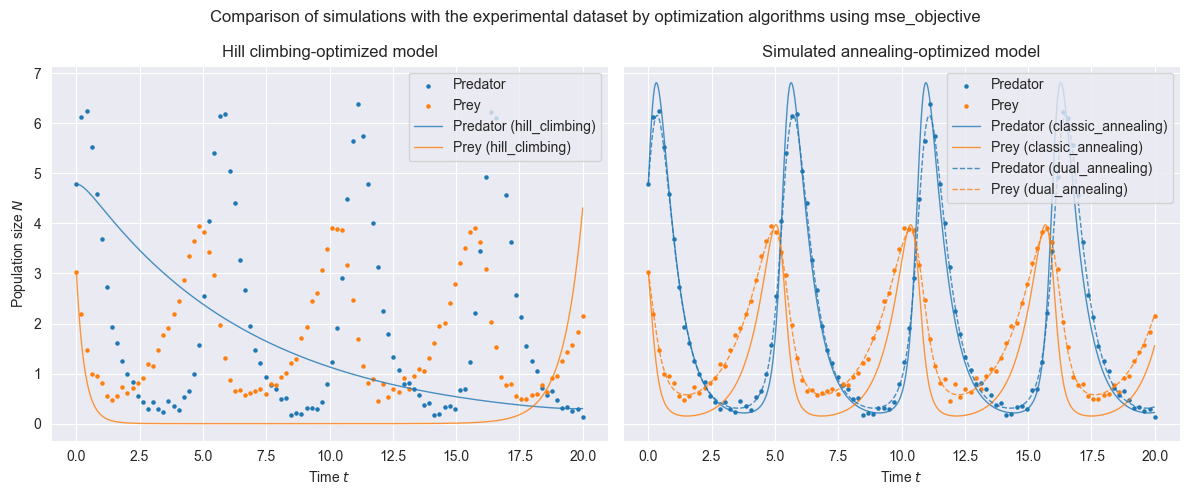

In [71]:
def plot_comparison_optimizers(hc_optimizers, sa_optimizers, objective=mse_objective, linestyles=['-', '--', ':'], colors=['tab:blue', 'tab:orange']):
    t_detail = np.linspace(0, 20, 1000)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), layout='tight', sharey=True)
    fig.suptitle(f'Comparison of simulations with the experimental dataset by optimization algorithms using {objective.__name__}')
    axs[0].scatter(t, x, s=5, label='Predator', color=colors[0])
    axs[0].scatter(t, y, s=5, label='Prey', color=colors[1])
    for i, opt in enumerate(hc_optimizers):
        params = est_params[opt.__name__][objective.__name__]
        initial_conditions = [y[0], x[0]]
        sim_data = solve_lv(params, initial_conditions, t_detail)
        axs[0].plot(t_detail, sim_data[:, 1], label=f'Predator ({opt.__name__})', linestyle=linestyles[i], color=colors[0], linewidth=1, alpha=0.8)
        axs[0].plot(t_detail, sim_data[:, 0], label=f'Prey ({opt.__name__})', linestyle=linestyles[i], color=colors[1], linewidth=1, alpha=0.8)
    axs[0].set_title('Hill climbing-optimized model')
    axs[0].set_xlabel('Time $t$')
    axs[0].set_ylabel('Population size $N$')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)
    axs[1].scatter(t, x, s=5, label='Predator', color=colors[0])
    axs[1].scatter(t, y, s=5, label='Prey', color=colors[1])
    for i, opt in enumerate(sa_optimizers):
        params = est_params[opt.__name__][objective.__name__]
        initial_conditions = [y[0], x[0]]
        sim_data = solve_lv(params, initial_conditions, t_detail)
        axs[1].plot(t_detail, sim_data[:, 1], label=f'Predator ({opt.__name__})', linestyle=linestyles[i], color=colors[0], linewidth=1, alpha=0.8)
        axs[1].plot(t_detail, sim_data[:, 0], label=f'Prey ({opt.__name__})', linestyle=linestyles[i], color=colors[1], linewidth=1, alpha=0.8)
    axs[1].set_title('Simulated annealing-optimized model')
    axs[1].set_xlabel('Time $t$')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)
    plt.savefig('media/comparison_optimizers.png')
    plt.show()

plot_comparison_optimizers(hc_optimizers, sa_optimizers)

Removing samples functionality

100%|██████████| 200/200 [05:58<00:00,  1.79s/it]


params: [0.94925496 0.49511404 1.72439373 0.87725044]
Minimum and Maximum of sim_data: 0.39829803286965204, 5.394269596399124
MSE: 0.08779208612175111


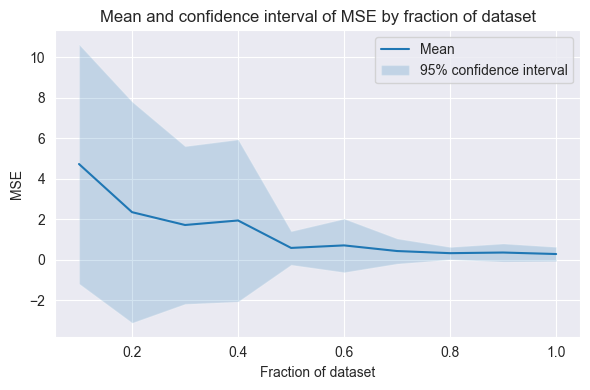

In [72]:
def gen_sample_dataset(data, frac):
    data = data.copy()
    return data.sample(frac=frac).sort_values(by='t').reset_index(drop=True)

def batch_comparison_by_frac(fracs, n_samples=10, optimizer=classic_annealing, objective=mse_objective, initial_conditions=[y[0], x[0]], **kwargs):
    results = []
    with tqdm(total=len(fracs)*n_samples) as pbar:
        for frac in fracs:
            mse = []
            for _ in range(n_samples):
                sample_data = gen_sample_dataset(data, frac)
                params = optimizer(objective, **kwargs).x
                sim_data = solve_lv(params, initial_conditions, sample_data['t'])
                mse.append(mean_squared_error(sample_data[['y', 'x']].values, sim_data))
                pbar.update()
            mean_mse, std_mse = np.mean(mse), np.std(mse)
            conf_int = sp.stats.norm.interval(0.95, loc=mean_mse, scale=std_mse)
            results.append([frac, mean_mse, std_mse, conf_int])
        logging.info(f"params: {params}")
        logging.info(f"Minimum and Maximum of sim_data: {sim_data.min()}, {sim_data.max()}")
        logging.info(f"MSE: {mean_squared_error(sample_data[['y', 'x']].values, sim_data)}")
    return pd.DataFrame(results, columns=['frac', 'mean', 'std', 'conf_int'])

try:
    fracs = np.linspace(0.1, 1.0, 10)
    experiment_df = batch_comparison_by_frac(fracs=fracs, n_samples=20, bounds=bounds, maxiter=MAX_ITER_SA)
except Exception as e:
    logging.error(f"An error occurred: {e}")

plt.figure(figsize=(6, 4), layout='tight')
plt.plot(experiment_df['frac'], experiment_df['mean'], label='Mean')
plt.fill_between(experiment_df['frac'], experiment_df['conf_int'].apply(lambda x: x[0]), experiment_df['conf_int'].apply(lambda x: x[1]), alpha=0.2, label='95% confidence interval')
plt.title('Mean and confidence interval of MSE by fraction of dataset')
plt.xlabel('Fraction of dataset')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('media/frac_conf_mse_sa.png')
plt.show()

In [73]:
def mse_objective(params, data):
    valid_data = data.dropna(subset=['y', 'x'])
    if valid_data.empty:
        return float('inf')
    
    initial_conditions = [valid_data['y'].iloc[0], valid_data['x'].iloc[0]]
    sim_data = solve_lv(params, initial_conditions, valid_data['t'])
    return mean_squared_error(valid_data[['y', 'x']].values, sim_data)

def mae_objective(params, data):
    valid_data = data.dropna(subset=['y', 'x'])
    if valid_data.empty:
        return float('inf')
    
    initial_conditions = [valid_data['y'].iloc[0], valid_data['x'].iloc[0]]
    sim_data = solve_lv(params, initial_conditions, valid_data['t'])
    return mean_absolute_error(valid_data[['y', 'x']].values, sim_data)

def smape_objective(params, data):
    valid_data = data.dropna(subset=['y', 'x'])
    if valid_data.empty:
        return float('inf')
    
    initial_conditions = [valid_data['y'].iloc[0], valid_data['x'].iloc[0]]
    sim_data = solve_lv(params, initial_conditions, valid_data['t'])
    absolute_percentage_error = 2 * np.abs((sim_data - valid_data[['y', 'x']].values) /
                                           (np.abs(sim_data) + np.abs(valid_data[['y', 'x']].values)))
    return np.nanmean(absolute_percentage_error)

In [74]:
def batch_comparison_by_frac(data, fracs, data_variable, n_samples=10,
                             optimizer=classic_annealing,
                             objective=mse_objective,
                             **kwargs):
    results = []
    with tqdm(total=len(fracs) * n_samples) as pbar:
        for frac in fracs:
            mse = []
            for _ in range(n_samples):
                sample_data = gen_sample_dataset(data, frac)
                params = optimizer(lambda params: objective(params, sample_data), **kwargs).x
                initial_conditions = [sample_data['y'].iloc[0], sample_data['x'].iloc[0]]
                sim_data = solve_lv(params, initial_conditions, sample_data['t'])
                mse.append(mean_squared_error(sample_data[data_variable].values, sim_data[:, {'y': 0, 'x': 1}[data_variable]]))
                pbar.update()
            mean_mse, std_mse = np.mean(mse), np.std(mse)
            conf_int = sp.stats.norm.interval(0.95, loc=mean_mse, scale=std_mse)
            results.append([frac, mean_mse, std_mse, conf_int])
        logging.info(f"params: {params}")
        logging.info(f"Minimum and Maximum of sim_data: {sim_data.min()}, {sim_data.max()}")
        logging.info(f"MSE: {mean_squared_error(sample_data[data_variable].values, sim_data[:, {'y': 0, 'x': 1}[data_variable]])}")
    return pd.DataFrame(results, columns=['frac', 'mean', 'std', 'conf_int'])

## Experiments and plots

 46%|████▋     | 93/200 [03:24<04:06,  2.30s/it]C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 96%|█████████▋| 193/200 [07:18<00:16,  2.31s/it]C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
100%|██████████| 200/200 [07:35<00:00,  2.28s/it]


params: [1.13306978 0.81327849 1.93627597 1.44380851]
Minimum and Maximum of sim_data: 0.07613156438763194, 6.189877024634228
MSE: 0.29775425319106946


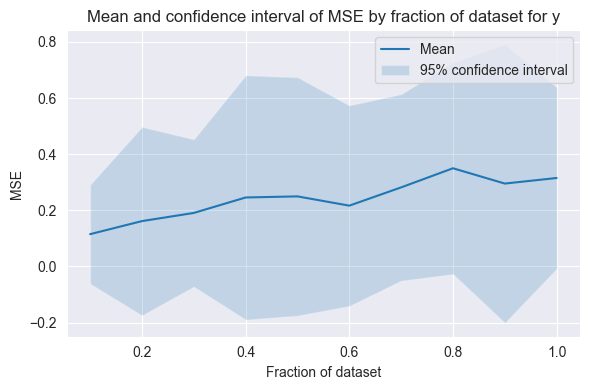

100%|██████████| 200/200 [07:46<00:00,  2.33s/it]


params: [1.05843076 0.41824845 1.40302068 0.66832683]
Minimum and Maximum of sim_data: 0.9120141157299892, 5.288057890279198
MSE: 0.6403542340886885


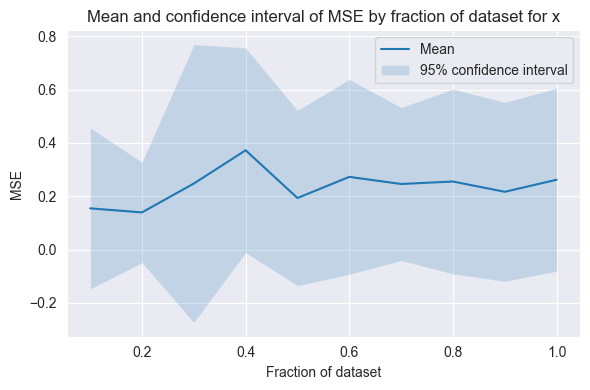

In [75]:
for data_variable in ['y', 'x']:
    try:
        experiment_df = batch_comparison_by_frac(fracs=fracs, data_variable=data_variable,
                                             n_samples=20, bounds=bounds, maxiter=MAX_ITER_SA,
                                             data=data)
    except Exception as e:
        logging.error(f"An error occurred: {e}")

    plt.figure(figsize=(6, 4), layout='tight')
    plt.plot(experiment_df['frac'], experiment_df['mean'], label='Mean')
    plt.fill_between(experiment_df['frac'],
                     experiment_df['conf_int'].apply(lambda x: x[0]),
                     experiment_df['conf_int'].apply(lambda x: x[1]),
                     alpha=0.2, label='95% confidence interval')
    plt.title(f'Mean and confidence interval of MSE by fraction of dataset for {data_variable}')
    plt.xlabel('Fraction of dataset')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

100%|██████████| 200/200 [07:55<00:00,  2.38s/it]


params: [1.17287644 0.62412279 1.55636623 1.00584498]
Minimum and Maximum of sim_data: 0.3007083033700853, 5.889752645820624
MSE: 0.08818722843386877


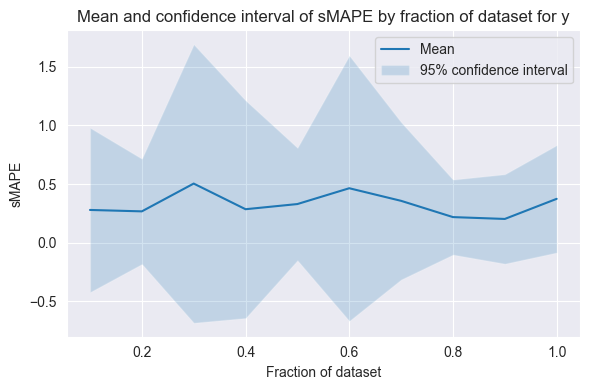

100%|██████████| 200/200 [07:30<00:00,  2.25s/it]


params: [1.50259893 0.85413276 1.18803614 0.59361844]
Minimum and Maximum of sim_data: 0.3142459667256389, 6.321243909800803
MSE: 0.29226310853191234


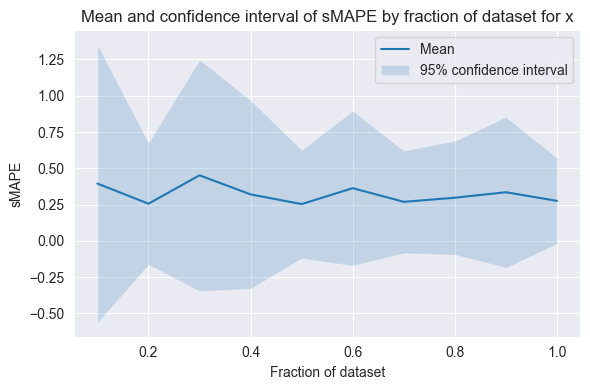

In [76]:
for data_variable in ['y', 'x']:
    try:
        experiment_df = batch_comparison_by_frac(fracs=fracs, data_variable='x', 
                                             n_samples=20, bounds=bounds, maxiter=MAX_ITER_SA, 
                                             data=data, objective=smape_objective)
    except Exception as e:
        logging.error(f"An error occurred: {e}")
    
    plt.figure(figsize=(6, 4), layout='tight')
    plt.plot(experiment_df['frac'], experiment_df['mean'], label='Mean')
    plt.fill_between(experiment_df['frac'],
                     experiment_df['conf_int'].apply(lambda x: x[0]),
                     experiment_df['conf_int'].apply(lambda x: x[1]),
                     alpha=0.2, label='95% confidence interval')
    plt.title(f'Mean and confidence interval of sMAPE by fraction of dataset for {data_variable}')
    plt.xlabel('Fraction of dataset')
    plt.ylabel('sMAPE')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

#### How many data-points from each time-series you could remove until you are not able to reverse-engineer the parameters any more?

First, try to find the importance of each time-series on reverse-engineering process by ﬁxing one time-series and removing data-points from the other one. In this way, you will ﬁnd the critical number of data-points for each time-series.

In [85]:
def prune_data_series(data, variable, frac_to_remove):
    logging.info(f"\nAttempting to prune {frac_to_remove*100}% of '{variable}' data...")
    if not isinstance(frac_to_remove, (float, int)):
        raise TypeError('frac_to_remove should be a float or an integer.')
    if not 0 <= frac_to_remove <= 1:
        raise ValueError('frac_to_remove should be between 0 and 1 inclusive.')

    num_data_to_prune = int(len(data) * frac_to_remove)
    logging.info(f"Number of data points to prune: {num_data_to_prune}")

    pruned_data = data.copy()
    if num_data_to_prune > 0:
        prune_indices = np.random.choice(data.index, size=num_data_to_prune, replace=False)
        pruned_data.loc[prune_indices, variable] = np.nan
        logging.info(f"Pruned data. Remaining data points: {pruned_data.dropna(subset=[variable]).shape[0]}")
    else:
        logging.warn("No data points to prune based on the fraction provided.")

    return pruned_data

In [86]:
def optimize_with_pruned_data(pruned_data, optimizer, objective_function, bounds):
    logging.info("\nOptimizing with pruned data...")
    valid_data = pruned_data.dropna(subset=['y', 'x'])
    if valid_data.shape[0] < 2:
        logging.info("Not enough data points after pruning to perform optimization.")
        return None, float('inf')

    initial_conditions = [valid_data['y'].iloc[0], valid_data['x'].iloc[0]]
    try:
        result = optimizer(lambda params: objective_function(params, valid_data), bounds=bounds, maxiter=MAX_ITER_SA)
        logging.info("Optimization successful.")
        return result.x, result.fun
    except Exception as e:
        logging.error(f"An error occurred during optimization: {e}")
        return None, float('inf')


Attempting to prune 0.0% of 'x' data...
Number of data points to prune: 0
No data points to prune based on the fraction provided.

Optimizing with pruned data...
Optimization successful.

Attempting to prune 10.0% of 'x' data...
Number of data points to prune: 10
Pruned data. Remaining data points: 90

Optimizing with pruned data...
Optimization successful.

Attempting to prune 20.0% of 'x' data...
Number of data points to prune: 20
Pruned data. Remaining data points: 80

Optimizing with pruned data...
Optimization successful.

Attempting to prune 30.0% of 'x' data...
Number of data points to prune: 30
Pruned data. Remaining data points: 70

Optimizing with pruned data...
Optimization successful.

Attempting to prune 40.0% of 'x' data...
Number of data points to prune: 40
Pruned data. Remaining data points: 60

Optimizing with pruned data...
Optimization successful.

Attempting to prune 50.0% of 'x' data...
Number of data points to prune: 50
Pruned data. Remaining data points: 50

Opt

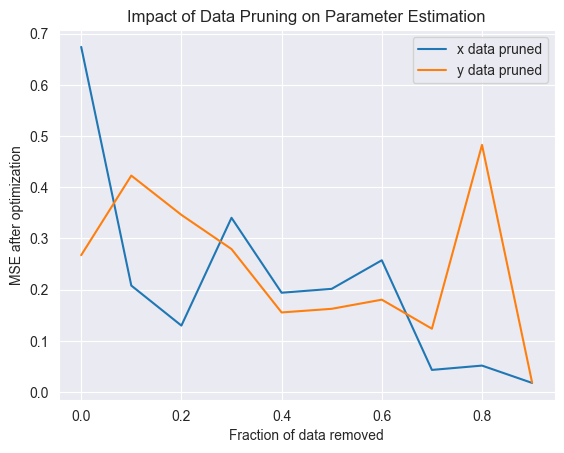

In [87]:
fractions = [round(float(i)/10, 1) for i in range(11)]
results = []

for variable in ['x', 'y']:
    for frac in fractions:
        pruned_data = prune_data_series(data, variable, frac)
        params, loss = optimize_with_pruned_data(pruned_data, classic_annealing, mse_objective, bounds)
        results.append({
            'variable': variable,
            'fraction_removed': frac,
            'mse': loss,
            'params': params
        })

results_df = pd.DataFrame(results)

for variable in ['x', 'y']:
    variable_results = results_df[results_df['variable'] == variable]
    plt.plot(variable_results['fraction_removed'], variable_results['mse'], label=f'{variable} data pruned')

plt.xlabel('Fraction of data removed')
plt.ylabel('MSE after optimization')
plt.legend()
plt.title('Impact of Data Pruning on Parameter Estimation')
plt.grid(True)
plt.show()


Attempting to prune 0.0% of 'x' data...
Number of data points to prune: 0
No data points to prune based on the fraction provided.

Optimizing with pruned data...
Optimization successful.

Attempting to prune 10.0% of 'x' data...
Number of data points to prune: 10
Pruned data. Remaining data points: 90

Optimizing with pruned data...
Optimization successful.

Attempting to prune 20.0% of 'x' data...
Number of data points to prune: 20
Pruned data. Remaining data points: 80

Optimizing with pruned data...
Optimization successful.

Attempting to prune 30.0% of 'x' data...
Number of data points to prune: 30
Pruned data. Remaining data points: 70

Optimizing with pruned data...
Optimization successful.

Attempting to prune 40.0% of 'x' data...
Number of data points to prune: 40
Pruned data. Remaining data points: 60

Optimizing with pruned data...
Optimization successful.

Attempting to prune 50.0% of 'x' data...
Number of data points to prune: 50
Pruned data. Remaining data points: 50

Opt

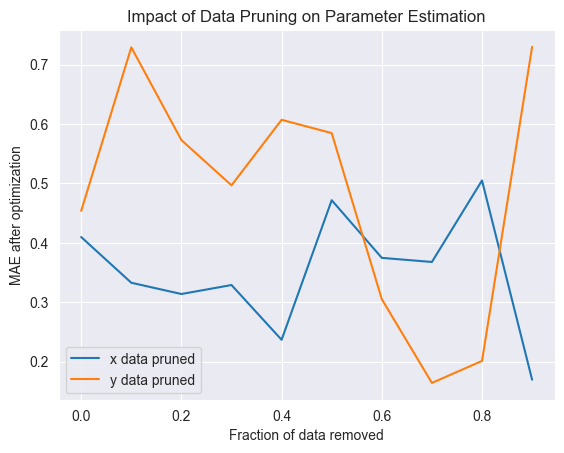

In [88]:
fractions = [round(float(i)/10, 1) for i in range(11)]
results = []

for variable in ['x', 'y']:
    for frac in fractions:
        pruned_data = prune_data_series(data, variable, frac)
        params, loss = optimize_with_pruned_data(pruned_data, classic_annealing, mae_objective, bounds)
        results.append({
            'variable': variable,
            'fraction_removed': frac,
            'mae': loss,
            'params': params
        })

results_df = pd.DataFrame(results)

for variable in ['x', 'y']:
    variable_results = results_df[results_df['variable'] == variable]
    plt.plot(variable_results['fraction_removed'], variable_results['mae'], label=f'{variable} data pruned')

plt.xlabel('Fraction of data removed')
plt.ylabel('MAE after optimization')
plt.legend()
plt.title('Impact of Data Pruning on Parameter Estimation')
plt.grid(True)
plt.show()


Attempting to prune 0.0% of 'x' data...
Number of data points to prune: 0
No data points to prune based on the fraction provided.

Optimizing with pruned data...
Optimization successful.

Attempting to prune 10.0% of 'x' data...
Number of data points to prune: 10
Pruned data. Remaining data points: 90

Optimizing with pruned data...
Optimization successful.

Attempting to prune 20.0% of 'x' data...
Number of data points to prune: 20
Pruned data. Remaining data points: 80

Optimizing with pruned data...
Optimization successful.

Attempting to prune 30.0% of 'x' data...
Number of data points to prune: 30
Pruned data. Remaining data points: 70

Optimizing with pruned data...
Optimization successful.

Attempting to prune 40.0% of 'x' data...
Number of data points to prune: 40
Pruned data. Remaining data points: 60

Optimizing with pruned data...
Optimization successful.

Attempting to prune 50.0% of 'x' data...
Number of data points to prune: 50
Pruned data. Remaining data points: 50

Opt

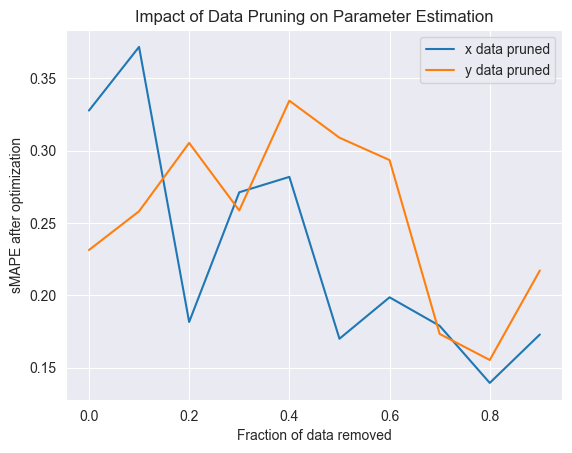

In [89]:
fractions = [round(float(i)/10, 1) for i in range(11)]
results = []

for variable in ['x', 'y']:
    for frac in fractions:
        pruned_data = prune_data_series(data, variable, frac)
        params, loss = optimize_with_pruned_data(pruned_data, classic_annealing, smape_objective, bounds)
        results.append({
            'variable': variable,
            'fraction_removed': frac,
            'smape': loss,
            'params': params
        })

results_df = pd.DataFrame(results)

for variable in ['x', 'y']:
    variable_results = results_df[results_df['variable'] == variable]
    plt.plot(variable_results['fraction_removed'], variable_results['smape'], label=f'{variable} data pruned')

plt.xlabel('Fraction of data removed')
plt.ylabel('sMAPE after optimization')
plt.legend()
plt.title('Impact of Data Pruning on Parameter Estimation')
plt.grid(True)
plt.show()

Then, if you combine two reduced time-series, could you still infer the parameters?

Does removing every data-point have the same effect on reverse-engineering process? In other words, what are the points that you could remove safely without affecting the inferance procedure? and what are those with critical effects on the process?

In [82]:
def leave_one_out_analysis(data, initial_guess, bounds, maxiter):
    importance_scores = []

    for i in range(len(data)):
        # Exclude one data point
        reduced_data = data.drop(index=i)
        t_reduced, x_reduced, y_reduced = reduced_data['t'].to_numpy(), reduced_data['x'].to_numpy(), reduced_data['y'].to_numpy()

        def mse_objective_reduced(params):
            initial_conditions = [y_reduced[0], x_reduced[0]]
            simulated = solve_lv(params, initial_conditions, t_reduced)
            mse = np.mean((simulated - reduced_data[['y', 'x']].values) ** 2)
            return mse

        # Fit the model on the reduced dataset
        result = dual_annealing(mse_objective_reduced, bounds=bounds, maxiter=maxiter)
        params = result.x
        mse = mse_objective_reduced(params)
        importance_scores.append((i, mse))

    return importance_scores

importance_scores = leave_one_out_analysis(data, initial_guess, bounds, MAX_ITER_SA)

# Sort the scores to see which data points had the most impact
importance_scores.sort(key=lambda x: x[1], reverse=True)
importance_df = pd.DataFrame(importance_scores, columns=['Data Point', 'MSE'])

# Sort the DataFrame by 'MSE' in descending order
importance_df = importance_df.sort_values(by='MSE', ascending=False)
importance_df.head(20)

C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\13520\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (

,Data Point,MSE
0,54,0.333177
1,49,0.225076
2,87,0.012078
3,44,0.010006
4,56,0.009777
5,23,0.009752
6,33,0.009735
7,45,0.009730
8,37,0.009730
9,73,0.009723


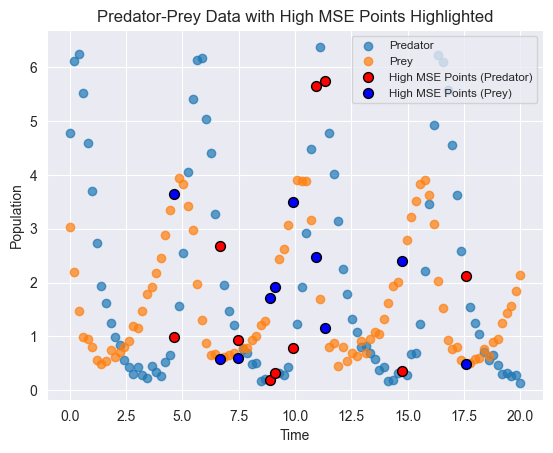

In [83]:
n_highlight = 10  

high_mse_indices = importance_df.head(n_highlight)['Data Point']

# Plot the original data
plt.scatter(data['t'], data['x'], label='Predator', alpha=0.7)
plt.scatter(data['t'], data['y'], label='Prey', alpha=0.7)

# Highlight the points with highest MSE
for idx in high_mse_indices:
    plt.scatter(data.loc[idx, 't'], data.loc[idx, 'x'], color='red', edgecolor='black', s=50, label='High MSE Points (Predator)' if idx == high_mse_indices.iloc[0] else "")
    plt.scatter(data.loc[idx, 't'], data.loc[idx, 'y'], color='blue', edgecolor='black', s=50, label='High MSE Points (Prey)' if idx == high_mse_indices.iloc[0] else "")

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Predator-Prey Data with High MSE Points Highlighted')
plt.legend(loc = "upper right", fontsize = 'small')
plt.savefig('media/datapoint_removal_plot.png')
plt.show()

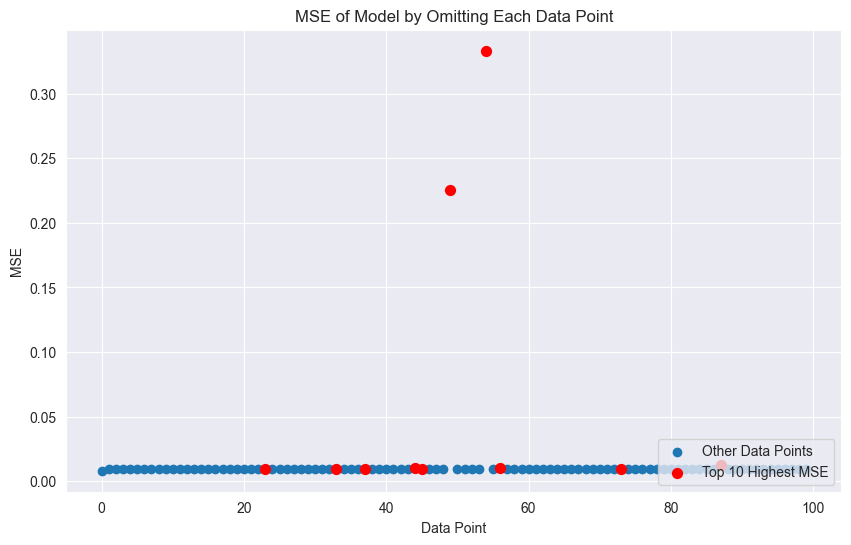

In [84]:
# Separating the top 10 highest MSE points
top_mse = importance_df.head(n_highlight)
other_mse = importance_df.iloc[n_highlight:]

# Plot 
plt.figure(figsize=(10, 6))
plt.scatter(importance_df['Data Point'], importance_df['MSE'], marker='o', linestyle='-', label='Other Data Points')

# Highlight the top 10 highest MSE values
plt.scatter(top_mse['Data Point'], top_mse['MSE'], color='red', s=50, label='Top 10 Highest MSE')

plt.xlabel('Data Point')
plt.ylabel('MSE')
plt.title('MSE of Model by Omitting Each Data Point')
plt.legend(loc="lower right")
plt.savefig('media/datapoint_removal_MSE_scatter.png')
plt.grid(True)
plt.show()

#### \<Extra question\>